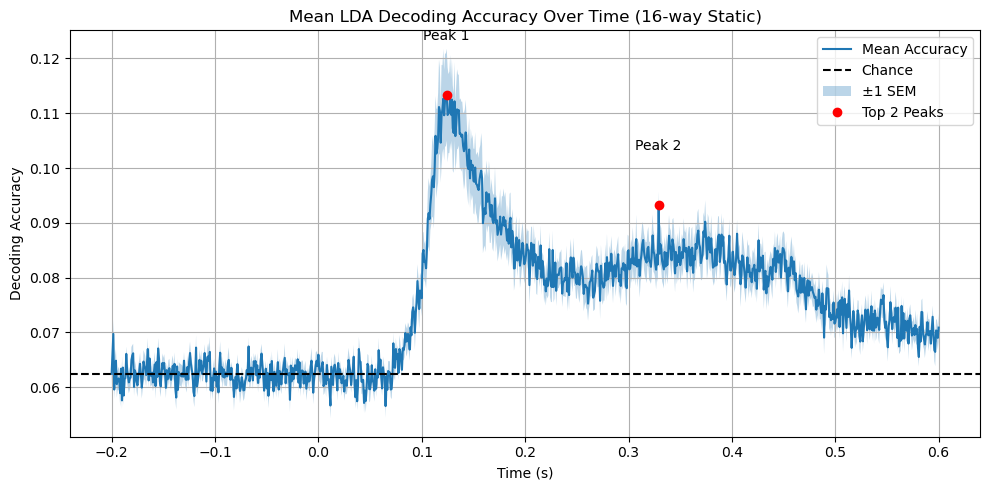

In [2]:
"""Load in the results for the 16-way classifier for each subject, conpute the mean across subjects,
and the peak times across subjects, save both. Then apply bayes factor statistical analyses."""

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import sem
import os
import csv
write_csv = False #Set to true to write mean peaks to Peak_Times.csv
# Output Path
output_dir = '/Users/sm6511/Desktop/NIH_Experiment/!Important Data/LDA-16way Static/data/r'
os.makedirs(output_dir, exist_ok=True)

# Input path
base_path = '/Users/sm6511/Desktop/NIH_Experiment/!Important Data/LDA-16way Static/data'
subjects = [f"S{i:02}" for i in range(1, 21)]

# Load all accuracy timecourses
all_accuracies = []
for subj in subjects:
    filepath = os.path.join(base_path, f"{subj}_DecodingAccuracyTimecourse.npy")
    if os.path.exists(filepath):
        data = np.load(filepath)
        all_accuracies.append(data)
    else:
        print(f"Missing: {filepath}")

# Stack and compute mean and SEM
all_accuracies = np.vstack(all_accuracies)
mean_acc = all_accuracies.mean(axis=0)
sem_acc = sem(all_accuracies, axis=0)

# Convert samples to time in seconds
sampling_rate = 1200  # Hz
n_timepoints = len(mean_acc)
start_time = -0.2  # in seconds
end_time = start_time + n_timepoints / sampling_rate
time = np.linspace(start_time, end_time, n_timepoints, endpoint=False)

# Find all peaks with at least 10-sample distance
peaks, _ = find_peaks(mean_acc, distance=10)

# Select the highest peak overall
peak1_idx = peaks[np.argmax(mean_acc[peaks])]

# Select the highest peak after 0.2 seconds
valid_second_peaks = [p for p in peaks if time[p] > 0.2]
if not valid_second_peaks:
    raise ValueError("No second peak found after 0.2 seconds.")
peak2_idx = valid_second_peaks[np.argmax(mean_acc[valid_second_peaks])]

# Sort peaks in time
final_peaks = np.sort([peak1_idx, peak2_idx])

# Compute peaks
peak1_sample = int(final_peaks[0])
peak2_sample = int(final_peaks[1])
peak1_time_ms = round(time[peak1_sample] * 1000, 3)
peak2_time_ms = round(time[peak2_sample] * 1000, 3)
if write_csv == True:
    # Path to existing Peak_Times.csv (from Step1A)
    peak_csv_path = os.path.join(output_dir, "Peak_Times.csv")

    # Check if the file exists and read header
    if not os.path.exists(peak_csv_path):
        raise FileNotFoundError(f"{peak_csv_path} does not exist.")

    # Read existing rows
    with open(peak_csv_path, mode='r', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        fieldnames = reader.fieldnames
        rows = list(reader)

    # Append new 'all' row
    new_row = {
        'Subject': 'all',
        'peak1_sample': peak1_sample,
        'peak1_time_ms': peak1_time_ms,
        'peak2_sample': peak2_sample,
        'peak2_time_ms': peak2_time_ms
    }
    # Replace 'all' row if it exists; otherwise append
    found = False
    for i, row in enumerate(rows):
        if row['Subject'] == 'all':
            rows[i] = new_row
            found = True
            break

    if not found:
        rows.append(new_row)


    # Write into csv
    with open(peak_csv_path, mode='w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(rows)
    print(f"Appended mean peaks to {peak_csv_path}")

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(time, mean_acc, label='Mean Accuracy')
plt.axhline(1.0 / 16.0, color='k', linestyle='--', label='Chance')

plt.fill_between(time, mean_acc - sem_acc, mean_acc + sem_acc, alpha=0.3, label='±1 SEM')

# Highlight peaks
plt.plot(time[final_peaks], mean_acc[final_peaks], 'ro', label='Top 2 Peaks')
for i, p in enumerate(final_peaks, 1):
    plt.text(time[p], mean_acc[p] + 0.01, f'Peak {i}', ha='center')
plt.xlabel('Time (s)')
plt.ylabel('Decoding Accuracy')
plt.title('Mean LDA Decoding Accuracy Over Time (16-way Static)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save plot
plot_path = os.path.join(output_dir, "MeanDecodingAccuracy.png")
#plt.savefig(plot_path, dpi=300)
plt.show()

In [4]:
import pandas as pd
output_dir = '/Users/sm6511/Desktop/NIH_Experiment/!Important Data/LDA-16way Static/data/r'
os.makedirs(output_dir, exist_ok=True)
# Convert to numpy array [subjects x timepoints]
all_accuracies = np.array(all_accuracies)
mean_acc = all_accuracies.mean(axis=0)
sem_acc = sem(all_accuracies, axis=0)

# Find peaks across mean timecourse
peaks, _ = find_peaks(mean_acc)
peak_times = peaks.tolist()

# Save mean and subject data to CSV for R
timepoints = np.arange(mean_acc.shape[0])
df = pd.DataFrame(all_accuracies, index=subjects, columns=timepoints)
df.to_csv(os.path.join(output_dir, "DecodingAccuracy_AllSubjects.csv"))

pd.DataFrame({
    "timepoint": timepoints,
    "mean_acc": mean_acc,
    "sem_acc": sem_acc
}).to_csv(os.path.join(output_dir, "DecodingAccuracy_Mean.csv"), index=False)

pd.DataFrame({"peak_timepoints": peak_times}).to_csv(
    os.path.join(output_dir, "DecodingAccuracy_Peaks.csv"), index=False
)

print("Saved: DecodingAccuracy_AllSubjects.csv, DecodingAccuracy_Mean.csv, DecodingAccuracy_Peaks.csv")


Saved: DecodingAccuracy_AllSubjects.csv, DecodingAccuracy_Mean.csv, DecodingAccuracy_Peaks.csv


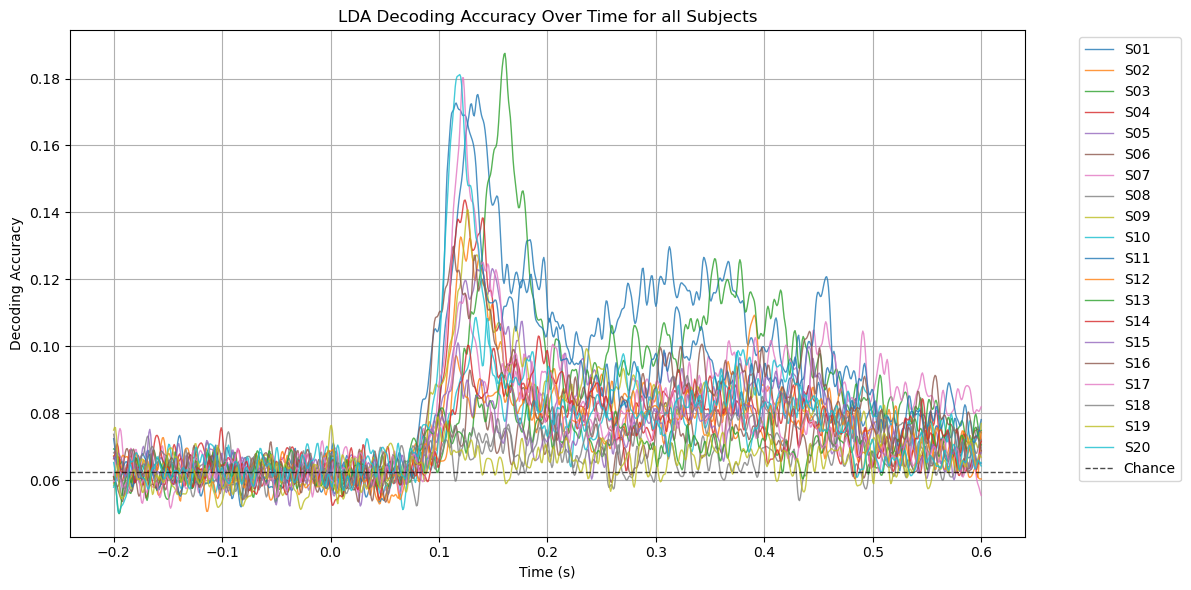

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter1d

base_path = '/Users/sm6511/Desktop/NIH_Experiment/!Important Data/LDA-16way Static/data'
output_dir = '/Users/sm6511/Desktop/Orientation-Imagery/Plots/Supplementary'
subjects = [f"S{i:02}" for i in range(1, 21)]

# Load all accuracy timecourses
all_accuracies = []
valid_subjects = []

for subj in subjects:
    filepath = os.path.join(base_path, f"{subj}_DecodingAccuracyTimecourse.npy")
    if os.path.exists(filepath):
        data = np.load(filepath)
        all_accuracies.append(data)
        valid_subjects.append(subj)
    else:
        print(f"Missing: {filepath}")

all_accuracies = np.vstack(all_accuracies)

# Convert samples to time in seconds
sampling_rate = 1200  # Hz
n_timepoints = all_accuracies.shape[1]
start_time = -0.2
end_time = start_time + n_timepoints / sampling_rate
time = np.linspace(start_time, end_time, n_timepoints, endpoint=False)

# Plot
plt.figure(figsize=(12, 6))

# Add transparency
for subj_idx, subj in enumerate(valid_subjects):
    smoothed = gaussian_filter1d(all_accuracies[subj_idx], sigma=2)
    plt.plot(time, smoothed, alpha=0.8, linewidth=1, label=subj) 

# Chance line (1/16)
plt.axhline(1/16, color='k', linestyle='--', linewidth=1, alpha=0.7, label='Chance')

plt.xlabel('Time (s)')
plt.ylabel('Decoding Accuracy')
plt.title('LDA Decoding Accuracy Over Time for all Subjects')
plt.grid(True)

# Place legend outside so 20 labels don't cover the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "AllSubjects_DecodingAccuracy.png"), dpi=300, bbox_inches='tight')
plt.show()



 R packages loaded successfully.
Loading subject decoding accuracies..
Loaded 20 subjects with shape (20, 961)
0.08916666666666667
First sustained decoding (>6) at 89.2 ms
Plotting group results with Bayes Factor significance..
Length mean_scores: 961
Length bf: 961


/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_29417/2178512767.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('bwr')


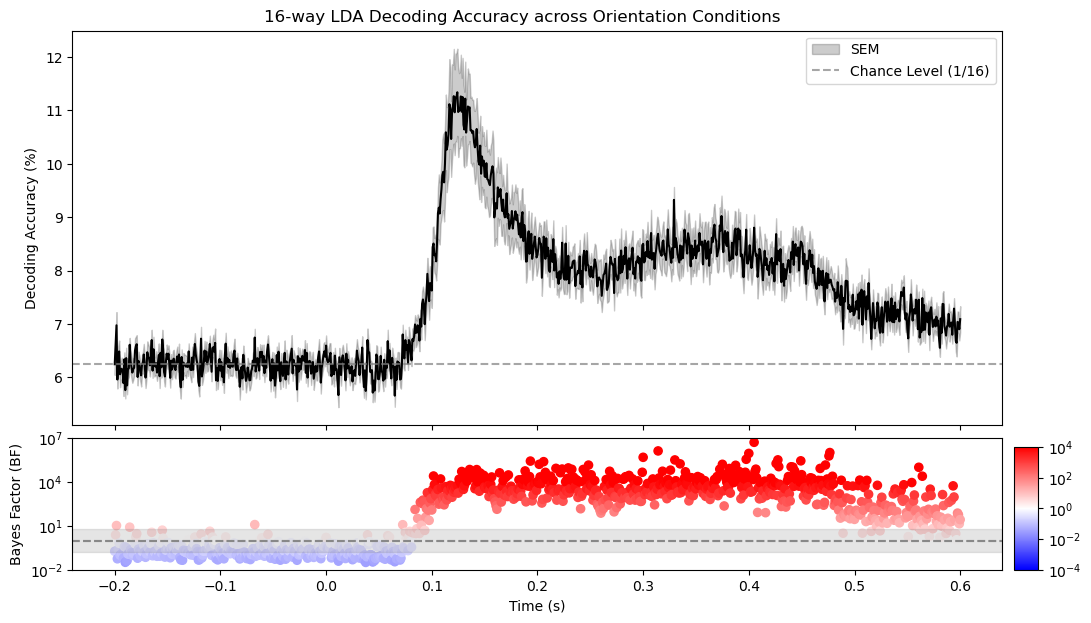

✅ Plot saved to /Users/sm6511/Desktop/NIH_Experiment/!Important Data/LDA-16way Static/data/Group_Mean_Scores_and_BayesFactors.png
Group plot saved at: /Users/sm6511/Desktop/NIH_Experiment/!Important Data/LDA-16way Static/data


In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import rpy2.robjects as ro
import rpy2.robjects.conversion as conversion
from rpy2.robjects import pandas2ri, default_converter
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
from matplotlib.colors import LogNorm

#Library path to r (will need to be adjusted for other environments)
ro.r('.libPaths("/opt/miniconda3/envs/mne2_arm/lib/R/library")')

#Conversion rules
conversion.set_conversion(default_converter + pandas2ri.converter)

#Import r
stringi = importr("stringi")
bayesfactor = importr("BayesFactor")

print(" R packages loaded successfully.")

#Parameters
chance = 1 / 16
mu = 0
nullMin = chance
nullMax = float('inf')
rscale = 'medium'
#n_timepoints = len(mean_scores)
start_time = -0.2  # seconds
end_time = 0.6     # seconds
# Time vector for plotting
times = np.linspace(start_time, end_time, n_timepoints)

# Functions

def load_subject_scores(decoding_dir):
    """Load decoding accuracy timecourses for all subjects."""
    subject_scores = []
    subject_ids = []

    for file in sorted(os.listdir(decoding_dir)):
        if file.endswith("_DecodingAccuracyTimecourse.npy"):
            subj_id = file.split("_")[0]
            filepath = os.path.join(decoding_dir, file)
            scores = np.load(filepath)
            subject_scores.append(scores)
            subject_ids.append(subj_id)

    return np.array(subject_scores), subject_ids


def compute_bayes_factors_group(data_2d):
    """Compute the BayesFactor for one person, given their accuracy scores."""
    normalized = data_2d - chance
    df = pd.DataFrame(normalized)  # wrap numpy array in pandas DataFrame

    bf = []
    for t in range(df.shape[1]):
        with localconverter(ro.default_converter + pandas2ri.converter):
            # Convert the single column (pandas Series) to R vector
            r_vector = ro.conversion.py2rpy(df.iloc[:, t])

        result = bayesfactor.ttestBF(
            x=r_vector,
            mu=mu,
            rscale=rscale,
            nullInterval=ro.FloatVector([nullMin, nullMax])
        )
        bf_value = np.array(ro.r['as.vector'](result))[0]
        bf.append(bf_value)

    return np.array(bf)

def find_latency(bf, times, threshold=6, n_consecutive=5):
    """Find the first timepoint where n_consecutive points exceed BF threshold."""
    above_thresh = bf > threshold
    # Slide a window of length n_consecutive to find a run of True values
    for i in range(len(above_thresh) - n_consecutive + 1):
        if np.all(above_thresh[i:i + n_consecutive]):
            latency_time = times[i]
            print(latency_time)
            print(f"First sustained decoding (>{threshold}) at {latency_time*1000:.1f} ms")
            return latency_time
    print("No sustained decoding above threshold found.")
    return None




def plot_group_results(mean_scores, bf, save_dir, times, data):
    """Plot mean decoding accuracy and Bayes Factors across timepoints."""
    print(f"Length mean_scores: {len(mean_scores)}")
    print(f"Length bf: {len(bf)}")

    log_bf = np.log10(bf)

    # Colormap setup
    cmap = cm.get_cmap('bwr')
    max_abs_logbf = 4
    norm = mcolors.TwoSlopeNorm(vmin=-max_abs_logbf, vcenter=0, vmax=max_abs_logbf)

    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(12, 7),
        gridspec_kw={'height_ratios': [3, 1]},
        sharex=True
    )

    # Top plot: mean decoding accuracy
    sem_scores = data.std(axis=0) / np.sqrt(data.shape[0])
    # Top plot: mean decoding accuracy
    ax1.plot(times, mean_scores*100, color='black')
    ax1.fill_between(times, (mean_scores - sem_scores)*100, (mean_scores + sem_scores)*100,
                    color='black', alpha=0.2, label='SEM')
    ax1.axhline(y=(1/16)*100, color='gray', linestyle='--', label='Chance Level (1/16)', alpha=.7)
    ax1.set_ylabel('Decoding Accuracy (%)')
    ax1.legend(loc='upper right')

    # Bottom plot: Bayes Factor dots
    ax2.scatter(times, bf, c=bf, cmap='bwr', norm=LogNorm(vmin=1e-4, vmax=1e4), s=35)

    ax2.set_yscale('log')
    ax2.set_ylabel('Bayes Factor (BF)')
    ax2.axhline(y=1, color='gray', linestyle='--', label='BF = 1', alpha=0.7)
    ax2.set_ylim(1e-2, 1e7)
    ax2.set_xlabel('Time (s)')

    # Colorbar with mirrored log scale
    sc = ax2.collections[0]  # get the scatter
    pos = ax2.get_position()
    cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])
    cbar = fig.colorbar(sc, cax=cbar_ax, orientation='vertical')
    #cbar.set_label('Bayes Factor (BF)')
        # Gray band for "chance / weak evidence" region
    bf_lower = 1/6  # BF < 1/6 is moderate evidence for null
    bf_upper = 6    # BF > 6 is moderate evidence for alternative
    ax2.axhspan(bf_lower, bf_upper, color='gray', alpha=0.2, label='Weak Evidence')
    ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.7)

    plt.subplots_adjust(hspace=0.05)
    save_path = os.path.join(save_dir, 'Group_Mean_Scores_and_BayesFactors.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    fig.suptitle('16-way LDA Decoding Accuracy across Orientation Conditions', fontsize=12, y=.91)
    plt.show()
    plt.close(fig)
    print(f"✅ Plot saved to {save_path}")


#Run

#Set paths
base_path = '/Users/sm6511/Desktop/NIH_Experiment/!Important Data/LDA-16way Static/data'
output_dir = '/Users/sm6511/Desktop/NIH_Experiment/!Important Data/LDA-16way Static/data'
os.makedirs(output_dir, exist_ok=True)

print("Loading subject decoding accuracies..")
data, subject_ids = load_subject_scores(base_path)
print(f"Loaded {len(subject_ids)} subjects with shape {data.shape}")

# Compute group mean and Bayes factors
mean_scores = data.mean(axis=0)
bf_group = compute_bayes_factors_group(data)

# --- Latency detection ---
latency = find_latency(bf_group, times, threshold=6, n_consecutive=5)


# Plot results
print("Plotting group results with Bayes Factor significance..")
plot_group_results(mean_scores, bf_group, output_dir, times, data)
print("Group plot saved at:", output_dir)


In [5]:
"""OLD VERSION OF ABOVE BLOCK"""

import rpy2.robjects as ro
import rpy2.robjects.conversion as conversion
from rpy2.robjects import pandas2ri, default_converter
from rpy2.robjects.packages import importr

# Ensure R libraries from your conda env are used
ro.r('.libPaths("/opt/miniconda3/envs/mne2_arm/lib/R/library")')

# Fix missing conversion rules
conversion.set_conversion(default_converter + pandas2ri.converter)

# Import R packages
stringi = importr("stringi")
bayesfactor = importr("BayesFactor")

print("R packages loaded successfully.")




# Parameters
chance = 1 / 16
mu = 0
nullMin = 0
nullMax = float('inf')
rscale = 'medium'
bf_threshold = 10  # BF threshold for significance

def load_subject_scores(decoding_dir):
    "Given a directory for decoding pulls out the decoding accuracy scores/IDs for one person"
    subject_scores = []
    subject_ids = []

    for file in sorted(os.listdir(decoding_dir)):
        if file.endswith("_DecodingAccuracyTimecourse.npy"):
            subj_id = file.split("_")[0]
            filepath = os.path.join(decoding_dir, file)
            scores = np.load(filepath)
            subject_scores.append(scores)
            subject_ids.append(subj_id)

    return np.array(subject_scores), subject_ids

def compute_bayes_factors_group(data_2d):
    "Compute the bayesfactor for one person, given their accuracy scores"
    normalized = data_2d - chance

    with localconverter(ro.default_converter + pandas2ri.converter):
        r_data = ro.conversion.py2rpy(pd.DataFrame(normalized))

    bf = []
    for t in range(normalized.shape[1]):
        result = bf_package.ttestBF(
            x=r_data.rx2(t + 1),
            mu=mu,
            rscale=rscale,
            nullInterval=ro.FloatVector([nullMin, nullMax])
        )
        bf.append(np.asarray(ro.r['as.vector'](result))[0])
    return np.array(bf)


def plot_group_results(mean_scores, bf, save_dir):
    "Plot scores and bayesfactor over time"
    print(f"Length mean_scores: {len(mean_scores)}")
    print(f"Length bf: {len(bf)}")

    times = np.arange(len(mean_scores))  # x-axis (time points)
    print(f"Length times: {len(times)}")
    # Convert BF to log10 scale
    log_bf = np.log10(bf)
    
    # Create a diverging colormap from dark blue (low BF) to white (BF=1) to dark red (high BF)
    cmap = cm.get_cmap('bwr') 
    # Normalize color around 0 with symmetric vmin/vmax so colors spread around BF=1
    max_abs_logbf = max(abs(log_bf.min()), abs(log_bf.max()))
    max_abs_logbf = 4
    norm = mcolors.TwoSlopeNorm(vmin=-max_abs_logbf, vcenter=0, vmax=max_abs_logbf)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), 
                                   gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    # Top plot: mean decoding accuracy
    ax1.plot(times, mean_scores, color='black', label='Mean Decoding Accuracy')
    ax1.axhline(y=1/16, color='gray', linestyle='--', label='Chance Level (1/16)')
    ax1.set_ylabel('Decoding Accuracy')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    # Bottom plot: Bayes Factor dots
    sc = ax2.scatter(times, bf, c=log_bf, cmap=cmap, norm=norm, s=35)
    ax2.set_yscale('log')
    ax2.set_ylabel('Bayes Factor (BF)')
    ax2.set_xlabel('Timepoint')
    ax2.grid(True, which='both', axis='y', alpha=0.3)
    # Remove bottom plot title for clean attachment
    ax2.set_title('')
    ax2.margins(y=0.1)

    pos = ax2.get_position()  # Bbox object: [x0, y0, width, height]

    cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])
    sc.set_clim(-max_abs_logbf, max_abs_logbf)
    cbar = fig.colorbar(sc, cax=cbar_ax, orientation='vertical')
    cbar.set_label('Evidence Strength')


    print(f"max_abs_logbf: {max_abs_logbf}")
    print(f"log_bf.min(): {log_bf.min()}, log_bf.max(): {log_bf.max()}")
    # Adjust layout to remove gaps and attach plots visually
    plt.subplots_adjust(hspace=0.05)

    # Save figure
    save_path = os.path.join(save_dir, 'Group_Mean_Scores_and_BayesFactors.png')
    #plt.savefig(save_path, dpi=150, bbox_inches='tight')
    #plt.close(fig)
    print(f"Plot saved to {save_path}")
    plt.plot()








decoding_dir = base_path
results_dir = output_dir
#exclude_subjs =  ['S19']

print("Loading subject decoding accuracies...")
data, subject_ids = load_subject_scores(decoding_dir)
print(data.shape)
print(f"Loaded {len(subject_ids)} subjects with shape {data.shape}")
subject_ids = np.array(subject_ids)
#keep_mask = ~np.isin(subject_ids, exclude_subjs)

#data = data[keep_mask]
#subject_ids = subject_ids[keep_mask]
mean_scores = data.mean(axis=0)
bf_group = compute_bayes_factors_group(data)

print("Plotting group results with BF significance...")
plot_group_results(mean_scores, bf_group, results_dir)
print("Done! Group plot saved at:", results_dir)




R packages loaded successfully.
Loading subject decoding accuracies...
(20, 961)
Loaded 20 subjects with shape (20, 961)


NameError: name 'bf_package' is not defined